# Sensors & Sensing
## Homework Assignment №3
---
## Anton Buguev BS19-RO-01
#### a.buguev@innopolis.university
#### 7 May 2022

The solution is adapted from https://docs.opencv.org/4.x/da/de9/tutorial_py_epipolar_geometry.html

### 1. Read images

Text(0.5, 1.0, 'Right image')

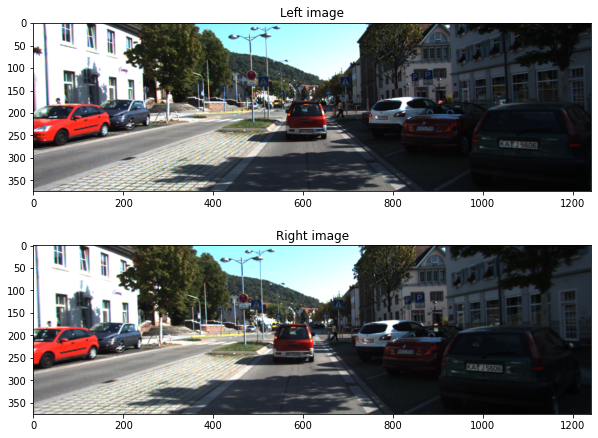

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
left_img = cv.cvtColor(cv.imread("left_000003.png"), cv.COLOR_BGR2RGB) # left image
right_img = cv.cvtColor(cv.imread("right_000003.png"), cv.COLOR_BGR2RGB) # right image

fig = plt.figure(figsize=(10, 7.5))
fig.add_subplot(2, 1, 1)
plt.imshow(left_img)
plt.title("Left image")

fig.add_subplot(2, 1, 2)
plt.imshow(right_img)
plt.title("Right image")

### 2. Convert images into gray format

In [2]:
left_img_gray = cv.cvtColor(left_img, cv.COLOR_RGB2GRAY)
right_img_gray = cv.cvtColor(right_img, cv.COLOR_RGB2GRAY)

### 3. Find keypoints using SIFT (Scale-Invariant Feature Transform)

In [3]:
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(left_img_gray, None)
kp2, des2 = sift.detectAndCompute(right_img_gray, None)

### 4. Match keypoints between images

In [4]:
# FLANN parameters
FLANN_INDEX_LINEAR = 0
index_params = dict(algorithm = FLANN_INDEX_LINEAR, trees = 5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
pts1 = []
pts2 = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

### 5. Draw detected keypoints on images

Text(0.5, 1.0, 'Right image keypoints')

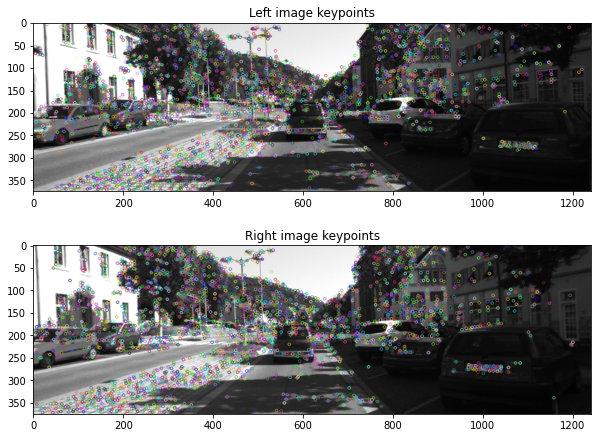

In [5]:
left_img_key_pts = cv.drawKeypoints(left_img_gray, kp1, left_img_gray.copy(), flags=cv.DRAW_MATCHES_FLAGS_DEFAULT)
right_img_key_pts = cv.drawKeypoints(right_img_gray, kp2, right_img_gray.copy(), flags=cv.DRAW_MATCHES_FLAGS_DEFAULT)

fig = plt.figure(figsize=(10, 7.5))

fig.add_subplot(2, 1, 1)
plt.imshow(left_img_key_pts, cmap='gray')
plt.title("Left image keypoints")

fig.add_subplot(2, 1, 2)
plt.imshow(right_img_key_pts, cmap='gray')
plt.title("Right image keypoints")

### 6. Calculate fundamnetal matrix

In [6]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)
print(f"Fundamental matrix:\n{F}")

Fundamental matrix:
[[-6.92660354e-07  2.99229273e-04 -5.58389027e-02]
 [-3.15853121e-04  2.13858884e-05 -4.08421199e+13]
 [ 5.99678833e-02  4.08421199e+13  1.00000000e+00]]


As we can see, the matrix is symmetric and corresponding elements are inverted which means our solution should be correct.

### 7. Find disparity map
Solution is taken from https://docs.opencv.org/4.x/dd/d53/tutorial_py_depthmap.html

By changing arguments of function **StereoBM_create** the result will have different "smoothness".

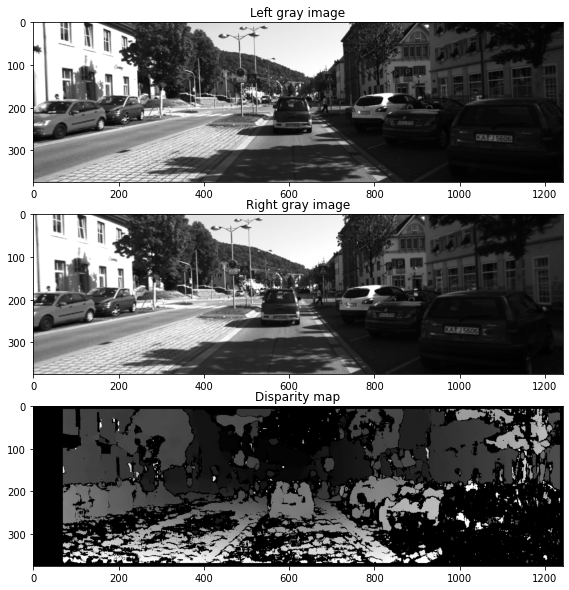

In [7]:
stereo = cv.StereoBM_create(numDisparities=0, blockSize=15)
disparity = stereo.compute(left_img_gray, right_img_gray)

fig = plt.figure(figsize=(15, 10))
fig.add_subplot(3, 1, 1)
plt.imshow(left_img_gray, cmap='gray')
plt.title("Left gray image")

fig.add_subplot(3, 1, 2)
plt.imshow(right_img_gray, cmap='gray')
plt.title("Right gray image")

fig.add_subplot(3, 1, 3)
plt.imshow(disparity,'gray')
plt.title("Disparity map")
plt.show()

This map shows which object "moved" more between images. The brighter the area on disparity map, the more object moved. That is why the closest objects to the camera (car, road, building) look brighter rather than objects which are far away (tree, street light, mountain).

Car on the right side is dark and is located in shade and just was not identified that is why it looks dark on disparity map even though it is the closest to the camera.

## Task 2

### Import data from **.csv** file which contains measurements from different sensors

During measurements I collected data from several different sensors but for our solution let us use only data from accelerometer and GPS, so we extract only corresponding columns.

Since data from GPS is in format of latitude and longitude let us find corresponding real-life coordinate using build-in function.

In [8]:
import pandas as pd
import numpy as np
import utm
import matplotlib.pyplot as plt
from numpy import linalg

data = pd.read_csv("data.csv")
data = data[["time", "ax", "ay", "Latitude", "Longitude"]]

time_arr = np.array(data[["time"]])
acc_x, acc_y = np.array(data[["ax"]]), np.array(data[["ay"]])
gps_x, gps_y, zone, ut = utm.from_latlon(np.array(data[["Latitude"]]), np.array(data[["Longitude"]]))

### Refactor data

Now we have data from GPS and accelerometer in arrays **gps_x**, **gps_y** and **acc_x**, **acc_y** respectively. Let us combine and reshape these arrays for convinient upcoming calculations. So instead of **gps_x** and **gps_y** we will have **pos_gps_data** with shape $(2, N)$ where $N$ is number of timesteps and instead of **acc_x** and **acc_y** we will have **acc_data** also with shape $(2, N)$. 

The only remaining part here is calculate displacement using data from accelerometer. To do so we need to calculate $v$ and position for each timestep using equations:
$$\begin{cases}
v_k = v_{k-1} + a_k*dt\\
p_k = p_{k-1} + v_k*dt
\end{cases}$$

So finally we will have array **pos_acc_data** with shape $(2, N)$.

In [9]:
pos_gps_data = np.hstack((gps_x, gps_y)).transpose()
acc_data = np.hstack((acc_x, acc_y)).transpose()
v_data = np.zeros(acc_data.shape)
pos_acc_data = np.zeros(acc_data.shape)
pos_acc_data[:,0] = [gps_x[0,0], gps_y[0,0]]

for i in range(1, len(time_arr)):
    dt = time_arr[i, 0] - time_arr[i-1, 0]
    v_data[:,i] = v_data[:,i-1] + acc_data[:,i] * dt
    pos_acc_data[:,i] = pos_acc_data[:,i-1] + v_data[:,i] * dt

## Define matrices

Let us define state vector as 
$$x_k=
\begin{bmatrix}
x\\
y\\
\dot{x}
\\
\dot{y}
\end{bmatrix}$$

Therefore trnsmition matrix $\Phi$ can be defined as
$$\Phi=
\begin{bmatrix}
1 & 0 & dt & 0\\
0 & 1 & 0 & dt\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1
\end{bmatrix}$$
such that 
$$\begin{bmatrix}
x\\
y\\
\dot{x}
\\
\dot{y}
\end{bmatrix}=
\begin{bmatrix}
1 & 0 & dt & 0\\
0 & 1 & 0 & dt\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
x\\
y\\
\dot{x}
\\
\dot{y}
\end{bmatrix}$$

Also we need to define matrix $H$. Let us say that matrix $z$ with data from sensors looks the following way:
$$z=\begin{bmatrix}
pos\_gps\_x\\
pos\_gps\_y\\
pos\_acc\_x\\
pos\_acc\_y
\end{bmatrix}$$
therefore matrix $H$ can be defined as
$$H=
\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0
\end{bmatrix}$$
such that
$$\begin{bmatrix}
pos\_gps\_x\\
pos\_gps\_y\\
pos\_acc\_x\\
pos\_acc\_y
\end{bmatrix}=
\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0
\end{bmatrix}\begin{bmatrix}
x\\
y\\
\dot{x}
\\
\dot{y}
\end{bmatrix}$$

And we need to define matrix $P$ which is error covariance, $Q$ - process noise covariance matrix and $R$ - sensor noise covariance matrix. For the simplicity let us make them identity matrices.

In [10]:
dt = 1
Phi = np.array([[1, 0, dt, 0],
            [0, 1, 0, dt],
            [0, 0, 1, 0],
            [0, 0, 0, 1]])

z_data = np.vstack((pos_gps_data, pos_acc_data))
H = np.array([[1, 0, 0, 0],
            [0, 1, 0, 0],
            [1, 0, 0, 0],
            [0, 1, 0, 0]])

I = np.eye(4) # identity matrix
P, Q, R = I, I, I

## Implement Multidimensional Kalman Filter

We create array for optimal values of position which we will calculate using Kalman Filter and initial position inside this array is initial position from GPS sensor. 

Finally, using corresponding equations for Multidimensional Kalman Filter we calculate optimal values of position.

In [13]:
data_opt = np.zeros((4, len(time_arr)))
data_opt[:2,0] = pos_gps_data[:,0]

for i in range(1, len(time_arr)):
    data_opt[:, i] = Phi @ data_opt[:, i-1]
    P = Phi @ P @ Phi.transpose() + Q

    K = P @ H.transpose() * linalg.inv(H @ P @ H.transpose() + R)

    data_opt[:,i] = data_opt[:,i] + K @ (z_data[:,i] - H @ data_opt[:,i])

    P = (I - K @ H) @ P

## Plot results.

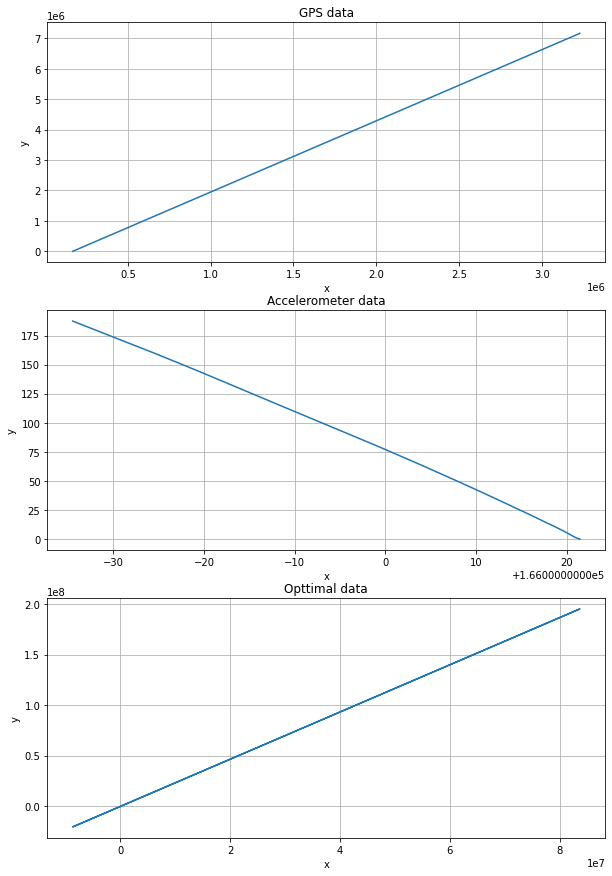

In [14]:
fig, (ax_gps, ax_acc, ax_opt) = plt.subplots(3, 1, figsize=(10, 15))

ax_gps.plot(pos_gps_data[0], pos_gps_data[1])
ax_gps.set_title("GPS data")
ax_gps.set_xlabel("x")
ax_gps.set_ylabel("y")
ax_gps.grid()

ax_acc.plot(pos_acc_data[0], pos_acc_data[1])
ax_acc.set_title("Accelerometer data")
ax_acc.set_xlabel("x")
ax_acc.set_ylabel("y")
ax_acc.grid()

ax_opt.plot(data_opt[0], data_opt[1])
ax_opt.set_title("Opttimal data")
ax_opt.set_xlabel("x")
ax_opt.set_ylabel("y")
ax_opt.grid()

plt.show()

## Conclusion
As we can see, our calculate trajectory almost corresponds to the measured GPS trajectory which proves that Kalman filter implemented correctly.